In [31]:
import pandas as pd
import numpy as np
import datetime

dfs = []
# Data is split into 79 files
for i in range(1,10):
    df = pd.read_csv(f"data/2022_place_canvas_history-00000000000{i}.csv.gzip", compression="gzip")
    dfs.append(df)
df = pd.concat(dfs)
df.head()

,timestamp,user_id,pixel_color,coordinate
0,2022-04-04 00:53:52.223 UTC,sRE+jCymbQBGQ1HclX0jMensZvALkc4Y+HDP+toTo5r2TC...,#009EAA,"256,1509"
1,2022-04-04 00:54:16.996 UTC,q16QRqtL5LoYHyLstUgCh6vjA9abo9l8VMGdBB3kUBVFyx...,#E4ABFF,"115,1930"
2,2022-04-04 00:54:23.386 UTC,D+HMqvb+xe+6MycijiENAngmcZB6fDIb+/Ebm/rr/q/ezT...,#94B3FF,"970,111"
3,2022-04-04 00:54:27.851 UTC,x3P7zSq4xUvvU/Ra7RvNPATw9GxVgempZ1+CQCghVciFcz...,#94B3FF,"863,1256"
4,2022-04-04 00:54:35.535 UTC,dh64bY7Cor0LTGLsrwtMgSwg9sP9koD+lGqlGyNWxArFel...,#94B3FF,"1956,395"


Pandas have a built-in data parser but in my experience, it is super slow (in this example it was about 7 times slower).

In [32]:
def parse_date(date):
    try:
        return datetime.datetime.strptime(date.strip(" UTC"), '%Y-%m-%d %H:%M:%S.%f')
    except ValueError:
        return datetime.datetime.strptime(date.strip(" UTC"), '%Y-%m-%d %H:%M:%S')

df['timestamp'] = df['timestamp'].apply(lambda x: parse_date(x))

Those cells are split to easily see the **runtime** of the **data parser**.

In [33]:
df['user_id'] = df['user_id'].astype('string')
df['pixel_color'] = df['pixel_color'].astype('string')

def parse_cord(cord):
    try:
        return float(cord.replace(",", "."))
    except ValueError:
        # Mods sometimes used the rectangle tool to censor NSFW, in those cases cords look like this (x1,y1,x2,y2).
        # With the code below we can get a tuple with opposite rectangle corners, but I didn't need that data.
        ###
        # cords = cord.split('.')
        # return (float(cord[0]+'.'+cord[1]), float(cord[2]+'.'+cord[3]))
        ###
        return np.NaN


df["coordinate"] = df["coordinate"].apply(lambda x: parse_cord(x))

df.dropna(how="any", inplace=True)
df.dtypes

timestamp      datetime64[ns]
user_id                string
pixel_color            string
coordinate            float64
dtype: object

### Prepare matplotlib
Each analysis will be split into three parts:
1. Description
2. Data editing
3. Ploting

In [34]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')
figsize = (20, 10)

#### Pixels per color
We are getting **number of pixels** placed depending on **color** of the **pixel**.

In [ ]:
colors = df["pixel_color"].value_counts().rename_axis('pixel_color').to_frame('counts').reset_index()
colors.head()

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
ax.bar(colors["pixel_color"], colors["counts"], color=colors["pixel_color"], edgecolor="#FFFFFF")
ax.set_title('Pixels placed per color')
ax.set_xlabel('color [hex]')
ax.set_ylabel('pixels placed')
plt.xticks(rotation=90)
fig.savefig('./plots/color_counts.pdf')

#### Max pixels placed per user based on color
Same thing as above but we are getting **maximum** number of **pixels** placed by **one user** based on **color**.

In [48]:
colors = df.iloc[:, 1:3]
colors['count'] = 1
colors= pd.pivot_table(colors, values='count', index='user_id', columns='pixel_color', aggfunc='count')

color_user = pd.DataFrame(columns=["pixel_color", "user_max"])
for name, column in colors.items():
    color_user = color_user.append({"pixel_color": name, "user_max": column.max()}, ignore_index = True)
color_user.sort_values(by='user_max', ascending = False, inplace=True)


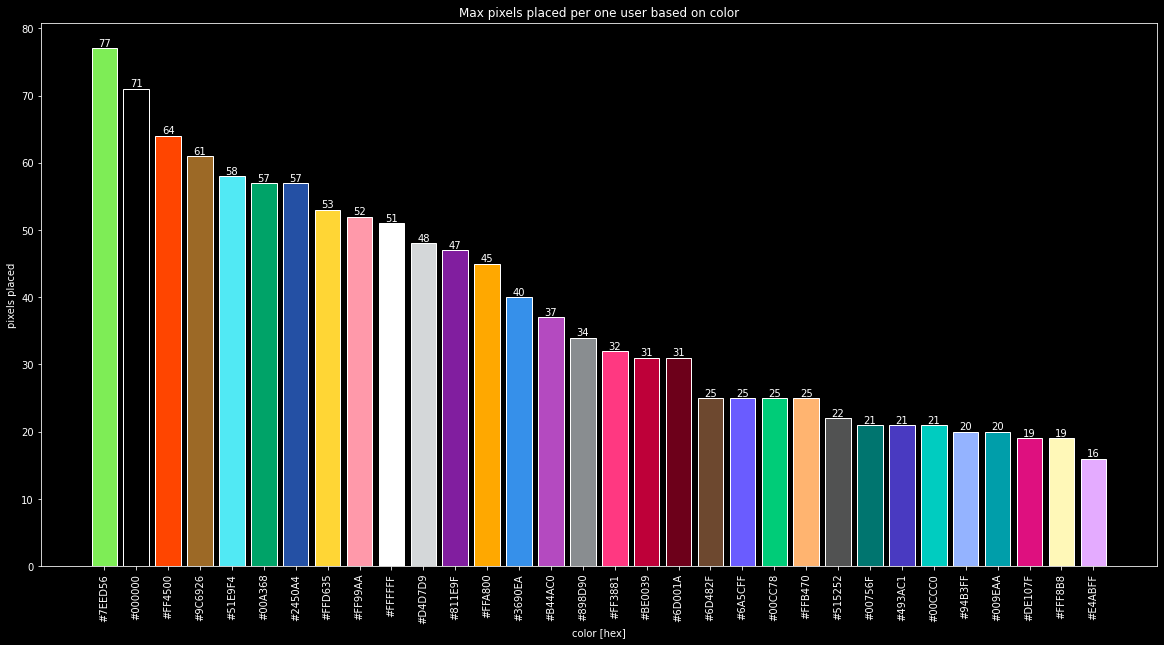

In [49]:
fig, ax = plt.subplots(figsize=figsize)
bars = ax.bar(color_user["pixel_color"], color_user["user_max"], color=color_user["pixel_color"], edgecolor="#FFFFFF")
ax.bar_label(bars)
ax.set_title('Max pixels placed per one user based on color')
ax.set_xlabel('color [hex]')
ax.set_ylabel('pixels placed')
plt.xticks(rotation=90)
fig.savefig('./plots/color_user_counts.pdf')

#### Distributioni of people who placed *x* many pixels.

In [59]:
pix_usr = df["user_id"].value_counts().to_frame('pixels').reset_index(drop=True)
# We will use pix_usr later on
pix_usr_count = pix_usr["pixels"].value_counts().rename_axis('pixels').to_frame('howmany')
pix_usr_count.head()

,howmany
pixels,
1,1469162
2,691505
3,430112
4,300286
5,207514


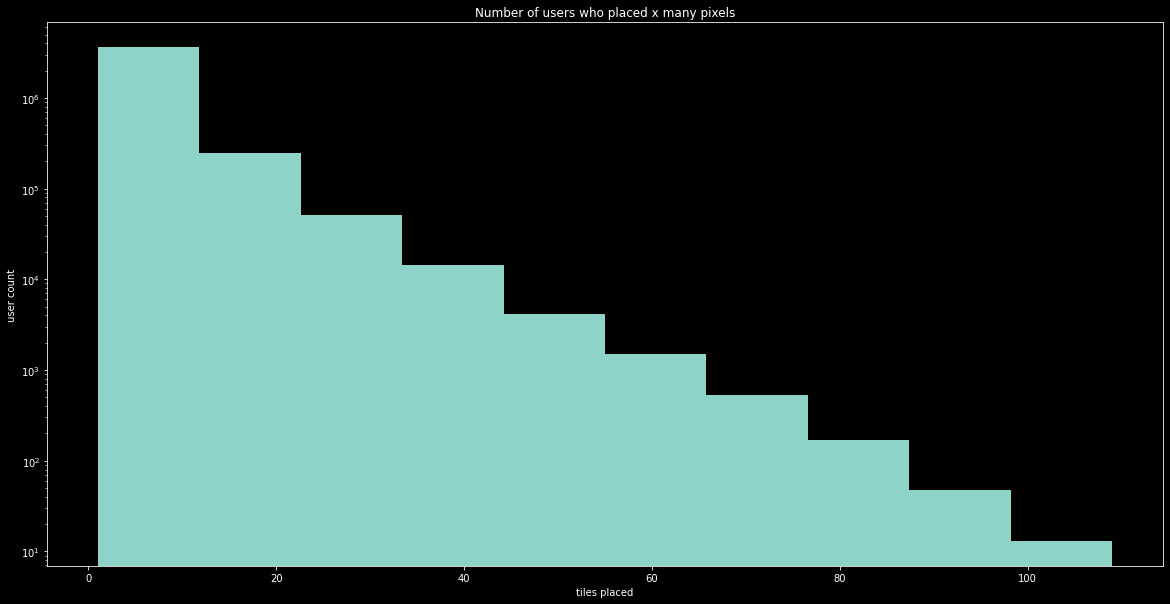

In [60]:
fig, ax = plt.subplots(figsize=figsize)
ax.set_yscale('log')
ax.set_ylabel('user count')
ax.set_xlabel('tiles placed')
ax.set_title('Number of users who placed x many pixels')
ax.hist(pix_usr['pixels'])
fig.savefig("./plots/tiles_per_user.pdf")

#### Top 10 users with maximum pixels placed

In [ ]:
pix_usr = pix_usr[:10]
pix_usr.index += 1

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
ax.set_ylabel('tiles placed')
ax.set_title('Pixels placed per user [Top 10]')
bars = ax.bar(['#'+str(i) for i in pix_usr.index], pix_usr['pixels'])
ax.bar_label(bars)
ax.set_ylim(ymin=min(pix_usr['pixels']-1))
fig.savefig('./plots/top10_tiles_per_user.pdf')

#### Heatmap of pixels
really sketchy but i spend like 7 hours on this plot

In [ ]:
def parse_cords(cord: float):
    cord = str(cord).split(".")
    h_map[int(cord[0])][int(cord[1])] += 1

In [ ]:
# Creating an array of pixel occurrences
h_map = np.zeros((2000, 2000), dtype='int')
cords = df["coordinate"].map(lambda cord: parse_cords(cord))
print(h_map)

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
ax = plt.imshow(h_map, interpolation='none', aspect='auto', vmax = 100)
plt.colorbar()
fig.savefig('./plots/pixels_heatmap.pdf')

#### Activity based on time of the day
How many **pixels** were **placed** based on **hour** of the day [UTC].

In [61]:
hourly = df["timestamp"].dt.strftime('%H').reset_index(drop=True)
hourly = hourly.value_counts().rename_axis("hour").to_frame("counts").sort_index()
hourly

,counts
hour,
00,435007
01,1034750
03,818973
04,1946465
05,808696
06,477368
15,1697040
16,1678345
17,1096042


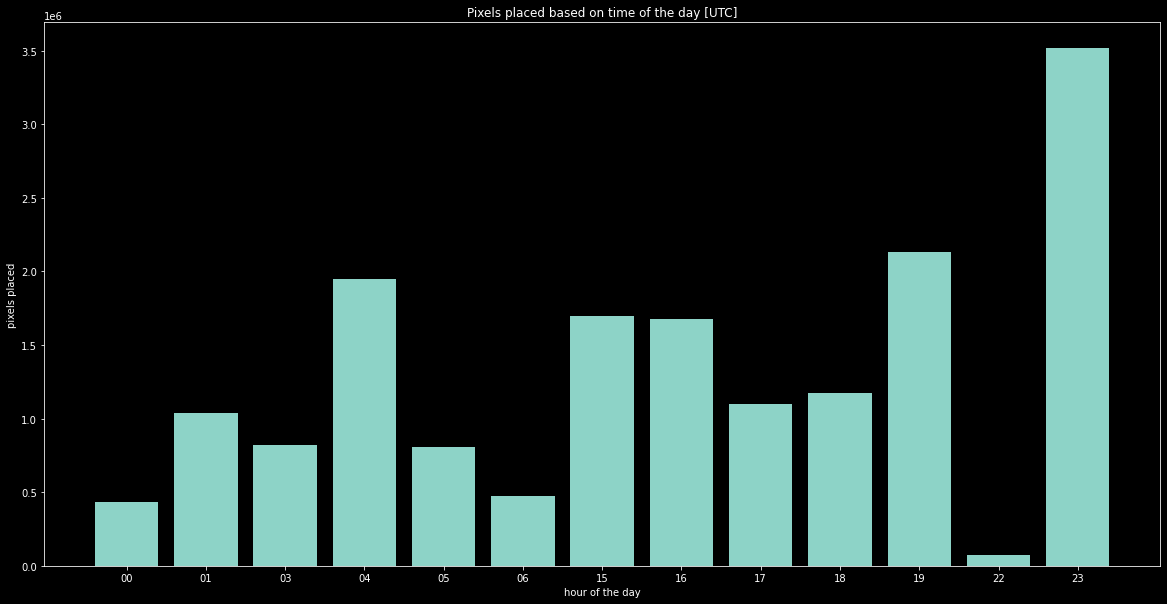

In [67]:
fig, ax = plt.subplots(figsize=figsize)
ax.bar(hourly.index.values, hourly["counts"])
ax.set_title('Pixels placed based on time of the day [UTC]')
ax.set_xlabel('hour of the day')
ax.set_ylabel('pixels placed')
fig.savefig('./plots/hourly_activity.pdf')